In [94]:
import time
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from deep_sort_realtime.deepsort_tracker import DeepSort

In [95]:
rgbVid = cv.VideoCapture('./media/pickPlaceTask_ball_zdiff--rgb.mp4')
print(f'Total frames rgb: {rgbVid.get(cv.CAP_PROP_FRAME_COUNT)}')

Total frames rgb: 1101.0


In [97]:
MODEL_CACHE_DIR = "/Users/rishiktiwari/AI/VLMs_test/hf_models"
MODEL_NAME = "CIDAS/clipseg-rd64-refined"
DEVICE = 'cpu'

processor = CLIPSegProcessor.from_pretrained(MODEL_NAME, cache_dir=MODEL_CACHE_DIR)
model = CLIPSegForImageSegmentation.from_pretrained(MODEL_NAME, cache_dir=MODEL_CACHE_DIR).to(DEVICE)

In [413]:
tracker = DeepSort(max_age=10)

In [414]:
def drawBbox(x,y,w,h, img, attentionImg):
    annImg = cv.resize(np.array(img), attentionImg.shape)
    cx = x+(w//2)
    cy = y+(h//2)
    print(f'bbox: {x},{y},{w},{h} mid: {cx},{cy}')

    cv.rectangle(annImg, (x,y),(x+w,y+h),(0,255,0), thickness=1)
    cv.circle(annImg, (cx, cy), radius=3, color=(255,0,255), thickness=-1)
    plt.imshow(annImg)
    plt.axis("off")

(480, 480, 3)


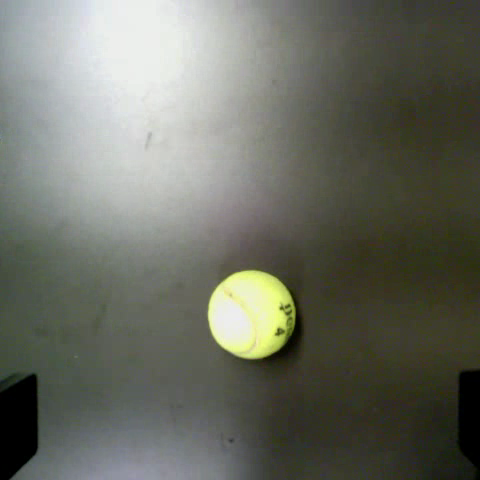

In [498]:
frameNumber = 190
rgbVid.set(cv.CAP_PROP_POS_FRAMES, frameNumber-1)
(rgbFlag, rgbFrame) = rgbVid.read()

(img_oh, img_ow, _) = rgbFrame.shape
crop_res_half = min(img_oh, img_ow) // 2
img_mid_w = img_ow//2 

rgbFrame = rgbFrame[:,img_mid_w - crop_res_half : img_mid_w + crop_res_half, :]
print(rgbFrame.shape)

image = Image.fromarray(rgbFrame[:,:,::-1])
display(image)

In [499]:
prompts = ["ball", "paper"]
inputs = processor(text=prompts, images=[image] * len(prompts), return_tensors="pt", padding="max_length").to(DEVICE)

# predict
start_time = time.perf_counter()
with torch.no_grad():
  outputs = model(**inputs)
end_time = time.perf_counter()

print("inference time: %.2fms" % ((end_time-start_time)*1000))

preds = outputs.logits.unsqueeze(1)

Unused or unrecognized kwargs: padding.


inference time: 546.82ms


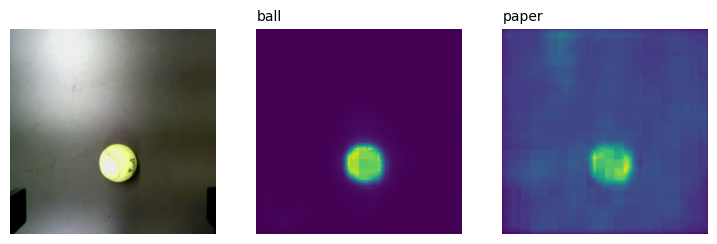

In [500]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

(352, 352)


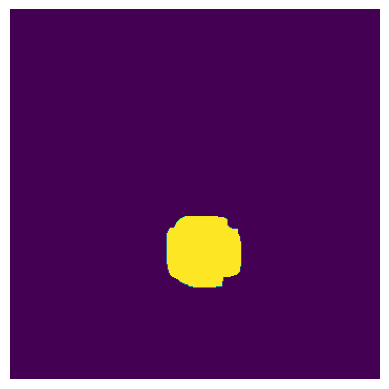

In [501]:
attentionImgArr = (np.array(torch.sigmoid(preds[0][0]))*255).astype(dtype=np.uint8)
print(attentionImgArr.shape)

ret, thresh = cv.threshold(attentionImgArr, 125, 255, cv.THRESH_BINARY)
thresh = cv.blur(thresh, (15,15)) # to reduce holes

contours,hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_TC89_KCOS)
if len(contours) == 0:
    print('--- NO CONTOURS ---')

# fill contours
for cnt in contours:
    cv.drawContours(thresh,[cnt], 0, 255, -1)

cnt = contours[0]
M = cv.moments(cnt)

plt.imshow(thresh)
plt.axis("off");

bbox: 182,232,1,1 mid: 182,232


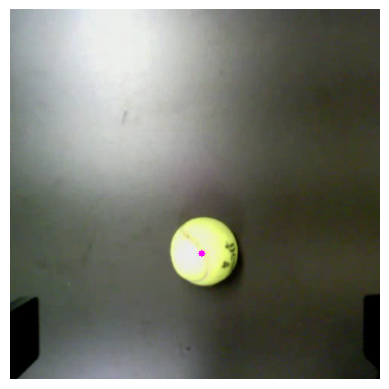

In [502]:
(x,y,w,h) = cv.boundingRect(cnt)
drawBbox(x, y, w, h, image, attentionImgArr)

In [503]:
bbox_confidence = 0.1 if min(h,w) < 10 else 0.7
bbs = [([x,y,w,h], bbox_confidence, 'label')] 
start_time = time.perf_counter()

tracks = tracker.update_tracks(bbs, frame=rgbFrame) # bbs expected to be a list of detections, each in tuples of ( [left,top,w,h], confidence, detection_class )
for track in tracks:
    if not track.is_confirmed():
        continue
    print(track.track_id)

end_time = time.perf_counter()
print("inference time: %.2fms" % ((end_time-start_time)*1000))

5
inference time: 128.59ms


In [504]:
predicted_bbox = tracks[0].to_ltwh().astype(dtype=int)
print(predicted_bbox)

[151 196  68  69]


bbox: 151,196,68,69 mid: 185,230


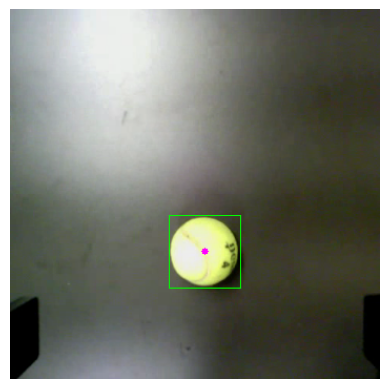

In [505]:
drawBbox(*predicted_bbox, image, attentionImgArr)